# Bayes Basics

In [2]:
import pymc3 as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
from scipy import stats

## Agenda
1. Bayesian Updating Intuition
2. Intro to Bayesian Formula
    * Bayes with point probabilities
    * There's so much more than point probabilities
3. Jumping into Deep End with PyMC3 and ArviZ
4. Breaking things apart
    * Priors
    * Likelihood
    * PPLs
    * The Magic Inference Button 
    * Posterior plots
3. Turning intuition into statistics using PyMC3 and ArviZ

## Bayesian Updating Intuition Exercise

Pretend this deck of cards is infinite, and you'll never see every single one so you can never be sure of the exact counts.

1. Before seeing any cards in this deck, what's the proportion of black and red?
2. If I draw 5 what is your belief in the proportion of red vs black in the deck?
3. If I draw 10 what is your belief in the proportion of red vs black in the deck?
4. How do your beliefs change as you see more cards?

### In person exercise
For those reading online, at this point I'll be

1. Drawing 0 cards and asking people to guess the proportion of red vs black?
2. Drawing 5 cards and asking people to guess the proportion of red vs black?
3. Drawing 10 cards and asking people to guess the proportion of red vs black?
4. After seeing 10 cards how sure are you that the deck is
    * 0% Red
    * 100% Red
    * 50% Red
    * 20% Red

In [ ]:
five_draws = []

In [ ]:
ten_draws = []

## Intro to Bayes Formula in a hurry
*Disclaimer*: I'm largely skipping over mathematical details so we can spend more time on intuition

The mathematical for Bayes Formula looks like this.

$$
\Large
p(\theta \mid y) = \frac{ p(y \mid \theta)p(\theta)}{p(y)}
$$

The idea of updating beliefs based on new data is captured in Bayes Formula. Notably we have

* The prior $p(\theta)$ which describes the belief in the world before seeing new data  

* The likelihood $p(y \mid \theta)$ which describes the probability of the "parameter" given the data  

* The posterior $ p(\theta \mid y)$ which is the updated belief after seeing the data

* The base rate $ p(y) $ which is the probability of the thing happening. Spoilers, this term difficult or impossible to ascertain in many situations so Modern Bayesian approaches utilize mathematical tricks to avoid calculating this.

### Math Aside
This formula is derived from a rearranging of terms for joint probabilities:

$$
P(\theta, y) = P(\theta)P(y | \theta) = P(y)P(\theta | y)
$$


### Point probability example
Here's an example taken from a data science blog post (https://towardsdatascience.com/what-is-bayes-rule-bb6598d8a2fd)
What is the probability of cancer given you're a smoker?

Assume 
$P(Cancer) = .05$ (Prior)  
$P(Smoker) = .1$ (Base Rate)  
$P(Smoker | Cancer) = .2)$ (Likelihood)  

In [8]:
p_cancer = .05
p_smoker = .1
p_smoker_given_cancer = .2

p_cancer_given_smoker = (p_smoker_given_cancer * p_cancer)/p_smoker
p_cancer_given_smoker

0.10000000000000002

While this "napkin" example of Bayes Theorem is simple and easily understood it's not very practical. Take a minute to take the cards draws we got above There are three challenges for practioners


#### Estimating range of outcomes
What do we do in non yes/no (binary) outcomes? For our card example we're interested in the proportion of red versus black cards in the deck. This isn't a yes/no question but rather a belief in a range of proportions from 0 to 1, not just one. 


#### Incorporating other factors
Additionally what if we know something else the patient, like smoker or non smoker, or gender? How do we easily incorporate? With point probabilities its possible but it gets messy fairly quickly

#### How did we get the point probabilities?
Where did any of these numbers come from? How do we know the base rate, or the probability of a positive test with cancer and no cancer? In practice these numbers are typically unavailable

### Distributions, Inference Algorithms, and Probabalistic Programming Languages,
Modern Bayesian Practioners rarely think or express Bayes Formula as shown above. Instead there's a couple of key differences.

1. We think in distributions of parameters and/or outcome, not just point probablities
    *  We want to see all shades of gray, the world isn't black and white,
2. We use Probabalistic Programming Languages to express ourselves.
    * We want to express complicated ideas to computers with ease. Probabilities notation doesn't let us do that
3. We use some clever math tricks and computers to estimate our beliefs, even without seeing all possible outcomes
    * We want estimates of the world without having to see the entire world


**Takeaways**
* There's way more to Bayes Formula than the point probability example.
* Bayesian Statisticians typically think about all outcomes, not just one outcome
* The combination of really neat math tricks, clever programmers, and very powerful computers give modern Bayesian Statisticians an easy to use and diverse toolset

## The deep end
Here's a fully built PyMC3 model with ArviZ posterior plots. Don't get wrapped up in the code at the moment, focus on the results an the intuition.

### Five observations
Given 5 observations how sure are we of the proportion of red cards?

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_red]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:06<00:00, 1766.29draws/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c202c4588>],
      dtype=object)

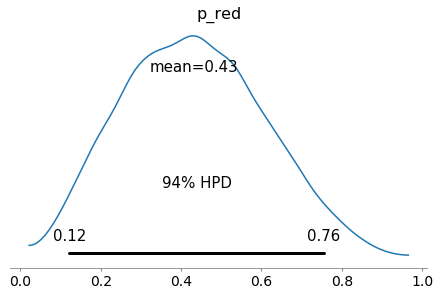

In [21]:
observations = [0, 0, 0, 1, 1]
red_observations = sum(observations)
total_observations = len(observations)
print(f"Number of Red Observations {red_observations}, Total Number of Observations {total_observations}")

with pm.Model() as five_obs_model:
    # Prior
    p_red = pm.Uniform("p_red", 0, 1)
    
    # Likelihood
    num_red = pm.Binomial("number_observed_red", p=p_red, n=total_observations, observed=red_observations)
    trace = pm.sample(draws=5000)
    
az.plot_posterior(trace)

### Ten observations
Given 10 observations how sure are we of the proportion of red cards?

Number of Red Observations 4, Total Number of Observations 10


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_red]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:05<00:00, 1932.14draws/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c20588f60>],
      dtype=object)

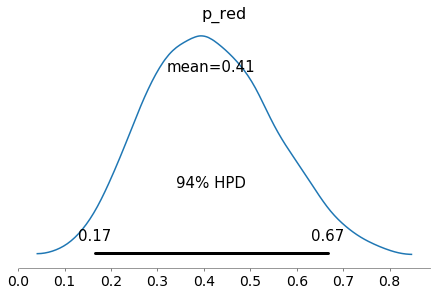

In [26]:
observations = [0, 0, 0, 1, 1]*2
red_observations = sum(observations)
total_observations = len(observations)
print(f"Number of Red Observations {red_observations}, Total Number of Observations {total_observations}")

with pm.Model() as ten_obs_model:
    # Prior
    p_red = pm.Uniform("p_red", 0 ,1)
    
    # Likelihood
    num_red = pm.Binomial("number_observed_red", p=p_red, n=total_observations, observed=red_observations)
    trace = pm.sample(draws=5000)

az.plot_posterior(trace)

Number of Red Observations 40, Total Number of Observations 100


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_red]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:05<00:00, 1968.20draws/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c1fe81b00>],
      dtype=object)

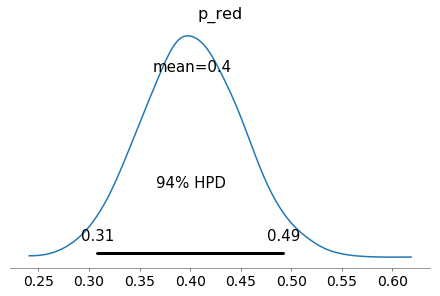

In [28]:
observations = [0, 0, 0, 1, 1]*20
red_observations = sum(observations)
total_observations = len(observations)
print(f"Number of Red Observations {red_observations}, Total Number of Observations {total_observations}")

with pm.Model() as one_hundred_obs_model:
    # Prior
    p_red = pm.Uniform("p_red", 0 ,1)
    
    # Likelihood
    num_red = pm.Binomial("number_observed_red", p=p_red, n=total_observations, observed=red_observations)
    trace = pm.sample(draws=5000)

az.plot_posterior(trace)

# Breaking this all apart
Now that you've seen a whole lot of Bayesian Models/Code let's break focus on each piece individually

## Step 1: Moving past point probabilities to distributions 

### Picking a prior
Let's start with priors. Before seeing any cards how do we express our beliefs? Picking priors and depending priors is an important part the Bayesian Practioners workflow.

#### I have no idea (Naive prior)
"I have no idea" is called the uniform distribution. Every value of proportion of red is equally likely from 0 t0 1

In [ ]:
possible_values_of_red = np.linspace(0,1, 1000)
belief_in_parameter = 

#### I've seen lots of decks of cards, its probably 50/50 red and black (Informed prior)

In [ ]:
# Add informed prior

**Takeaways**
* Priors encode the belief before data is seen
* Priors can be distributions of beliefs, not just one belief
* Choice of prior is a powerful tool in the Bayesian Workflow

### Likelihood: Given the observations how likely is the parameter

We will be using binomial distribution as likelihood. Binomial distribution helps describe "If there's only two possibilities for each outcome, will things look like with $\theta$ probability".
    * $\theta$ = 1 means you think every single card is red, so its only possible to draw red cards.
    * $\theta$ = 0 means you think no card is red, so its not possible to draw any red card. 
    * $\theta$ =.4 means you think 4 out of 10 cards are red, so some draws will be red, but most will be black. 
    
How did I pick a Binomial distribution? In this case that data generated is a set of binary outcomes. 
If I were estimating peoples heights I would use the Normal distribution because I know the data is continuous and likely symmetrical

If I were estimating how many people arrive at a grocery store line I would use the Poisson distribution, because it exists only on natural numbers (positive integers)'

Picking likelihoods is an important ask for Bayesian Practioners

## Step 2: Expressing model using a Probabalistic Programming Language
We've seen the following data, how can estimate our belief in proportion of red?

In [ ]:
# A value of 0 signifies a black card observation, a value of 1 signifies a red card observation
observations = [0, 0, 1, 0, 1]
red_observations = sum(observations)
total_observations = len(observations)

Let's recap our choice of prior and likelihood

We are trying to estimate $\theta$ where
$$\theta = \text{Proportion of red cards}$$

Your model is formulated as follows, the top line being our prior belief before seeing any data, and the bottom line being our likelihood.

$$ 
\theta \sim \operatorname{Uniform}(0,1) \\
p_{\text{red_cards}} \sim \operatorname{Binom}(\theta, N)
$$


Let's express this again in the "special" PyMC3 language. The two lines should look vaguely familiar as the prior and likelihood.

Note a couple of things:
    1. In PyMC3 we "tell" python we're building a model with the `with` context manager
    2. We incorporate data into our likelihood with the `observed` argument

In [4]:
with pm.Model() as five_obs_model:
    # Prior
    p_red = pm.Uniform("p_red", 0 ,1)
    
    # Likelihood
    num_red = pm.Binomial("number_observed_red", p=p_red, n=total_observations, observed=red_observations)

NameError: name 'θ' is not defined

The above model definition looks great, no actual inference (belief estimation) has happened yet. To do that we hit "the magic inference button" as Thomas Wiecki calls it. In PyMC3 it looks like this.

*Note*: We don't have to restate the whole model in PyMC3 but I'm choosing to do so for clarity

In [ ]:
with pm.Model() as five_obs_model:
    # Prior
    p_red = pm.Uniform("p_red", 0 ,1)
    
    # Likelihood
    num_red = pm.Binomial("number_observed_red", p=p_red, n=total_observations, observed=red_observations)
    
    trace_5 = pm.sample(5000)

In [ ]:
# A value of 0 signifies a black card observation, a value of 1 signifies a red card observation
observations = [0, 0, 1, 0, 1]
red_observations = sum(observations)
total_observations = len(observations)

## Fake a bunch of data. Fit distribution
A great way to understand ML algorithms is generate data, so you know the truth, then fit a model to your generated data to see what happens.

This is where you get to play around. Suggestions are

1. Generate a large amount (size=1000) at a p value of your choice. See if you can write a model to "rediscover" the parameter
2. Change the p value and generate a large amount again. See how the posterior plot changes
3. Challenge: Generate a normal distribution with with a mean and standard deviation of your choice. See if you can use Bayesian inference to "find the parameters"
    * Hint: You'll need two priors, one for the mean and one for the standard deviation
    * Hint: Your likelihood will need to change from Binomial because now your data generatation is charecterisic of another function

In [6]:
# Fix binomal drawsl ater
from scipy.stats import binom
obs = binom(p=.5).rvs(size=100)

TypeError: _parse_args() missing 1 required positional argument: 'n'